# COMP41680 Assignment 2



### Aryan Vikas Jain(22204474)

## Necessary Imports

In [222]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from scipy.stats.mstats import winsorize

from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler,OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics import roc_auc_score ,mean_squared_error,r2_score,accuracy_score,roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#Classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier 
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB

## Task 1. Data Preparation

### Tabular Data

In [249]:
# Data Import
path = '/content/drive/MyDrive/Data Science Assignment 2/bank-tabular.csv'
df = pd.read_csv(path, delimiter='\t')
df.head()

,customer_id,date,customer_gender,customer_age,customer_location,customer_type,has_cc,has_mortgage,convenience,customer_service,online_banking,interest_rates,fees_charges,community_involvement,products_services,privacy_security,reputation,satisfied
0,216604,2022-08-22,Male,50.0,Munster,Personal,True,False,4.0,5.0,4.0,4.0,4.0,4.0,5.0,2.0,4.0,True
1,259276,2022-11-23,Female,61.0,Leinster,Personal,True,False,5.0,5.0,5.0,3.0,5.0,4.0,4.0,5.0,5.0,True
2,265459,2022-01-21,Female,63.0,Munster,Business,True,False,2.0,2.0,5.0,5.0,2.0,NaN,4.0,4.0,NaN,True
3,58770,2022-03-13,f,NaN,Leinster,Business,True,False,NaN,4.0,5.0,1.0,5.0,5.0,5.0,5.0,5.0,True
4,318031,2022-08-08,Female,41.0,Leinster,Personal,True,True,1.0,1.0,1.0,1.0,2.0,2.0,4.0,5.0,2.0,False


In [250]:
print('Shape of the data is: ',df.shape)

Shape of the data is:  (3000, 18)


In [251]:
# IDENTIFYING NUMERICAL FEATURES

numeric_data = df.select_dtypes(include=np.number) # select_dtypes selects data with numeric features
numeric_col = numeric_data.columns               # we will store the numeric features in a variable

print("Numeric Features:")
numeric_data.head()
# print("===="*20)

Numeric Features:


,customer_id,customer_age,convenience,customer_service,online_banking,interest_rates,fees_charges,community_involvement,products_services,privacy_security,reputation
0,216604,50.0,4.0,5.0,4.0,4.0,4.0,4.0,5.0,2.0,4.0
1,259276,61.0,5.0,5.0,5.0,3.0,5.0,4.0,4.0,5.0,5.0
2,265459,63.0,2.0,2.0,5.0,5.0,2.0,NaN,4.0,4.0,NaN
3,58770,NaN,NaN,4.0,5.0,1.0,5.0,5.0,5.0,5.0,5.0
4,318031,41.0,1.0,1.0,1.0,1.0,2.0,2.0,4.0,5.0,2.0


In [252]:
# IDENTIFYING CATEGORICAL FEATURES
categorical_data = df.select_dtypes(exclude=np.number) # we will exclude data with numeric features
categorical_col = categorical_data.columns             # we will store the categorical features in a variable


print("Categorical Features:")
categorical_data.head()
# print("===="*20)

Categorical Features:


,date,customer_gender,customer_location,customer_type,has_cc,has_mortgage,satisfied
0,2022-08-22,Male,Munster,Personal,True,False,True
1,2022-11-23,Female,Leinster,Personal,True,False,True
2,2022-01-21,Female,Munster,Business,True,False,True
3,2022-03-13,f,Leinster,Business,True,False,True
4,2022-08-08,Female,Leinster,Personal,True,True,False


### Data Preprocessing


In [253]:
counts = df['customer_id'].value_counts()

# Filter for exact multiple entries (more than 1)
multiple_entries = counts[counts > 1]

for customer_id, count in multiple_entries.items():
    # Get the rows where the customer_id appears
    rows = df.loc[df['customer_id'] == customer_id]
    
    # Check if all rows are the same
    if rows.nunique().eq(1).all():
        print(f"Customer ID {customer_id} appears {count} times in the column, with identical entries.")
    else:
        print(f"Customer ID {customer_id} appears {count} times in the column, with different entries.")

During our analysis, we found that there were only two customer IDs with multiple entries in the dataset. However, upon further investigation, we discovered that these entries had different values for other columns, such as "customer_gender" and "customer_location". Therefore, we can conclude that these multiple entries do not represent any data quality issues, and we can use all the data from the dataset as it does not have any repeat entries that could potentially impact our analysis. It is always crucial to perform a thorough investigation and analysis of the data to ensure that the results obtained are reliable and accurate.

#### Modifying Numerical Features

Missing values in the dataset can significantly affect the performance of classification models. In our Bank dataset, we found several numerical features with missing values. We used the median imputation technique to treat these missing values. Median imputation is a widely used technique for treating missing values in numerical datasets. Unlike mean imputation, which replaces missing values with the average value, median imputation is robust to outliers. It is a more reliable way of filling missing values, especially when dealing with numerical datasets with skewed distributions.

In [254]:
# To identify the number of missing values in every feature

# Finding the total missing values and arranging them in ascending order
total = df.isnull().sum()

# Converting the missing values in percentage
percent = (df.isnull().sum()/df.isnull().count())

# dropping features having missing values more than 60%
df = df.drop((percent[percent > 0.6]).index,axis= 1)

# checking null values
print(df.isnull().sum())

customer_id                0
date                       0
customer_gender          312
customer_age             470
customer_location        365
customer_type              0
has_cc                     0
has_mortgage               0
convenience               64
customer_service          29
online_banking            30
interest_rates           165
fees_charges              76
community_involvement    300
products_services        100
privacy_security         262
reputation               402
satisfied                  0
dtype: int64


In [255]:
# #adding mean to the missing values in customer_age Column
# mean = df["customer_age"].mean()
# df["customer_age"].fillna(mean,inplace = True)

#imputing with median values to the rest of the numerical columns
for column in numeric_col:
    median = df[column].median()
    df[column].fillna(median, inplace = True)

print(df.isnull().sum())

customer_id                0
date                       0
customer_gender          312
customer_age               0
customer_location        365
customer_type              0
has_cc                     0
has_mortgage               0
convenience                0
customer_service           0
online_banking             0
interest_rates             0
fees_charges               0
community_involvement      0
products_services          0
privacy_security           0
reputation                 0
satisfied                  0
dtype: int64


#### Modifying Categorical Features

In the preprocessing step of the Bank dataset, we observed missing values in the categorical columns "customer_gender" and "customer_location". We dealt with the missing values in "customer_gender" column by replacing the other values with "Male", "Female", and "Not Specified". This was done to reduce the number of unique values and to make the column more consistent. We then replaced the remaining missing values with "Not Specified" to ensure that the data is complete.

In the "customer_location" column, we noticed missing values that could not be replaced with any specific value. Therefore, we replaced the missing values with "Other Location" in order to retain the data and to ensure that the data remains usable.

In [256]:
print("Unique Values for Categorical Features:")
print('customer_gender' + ': ' + str(df['customer_gender'].unique()))
print('customer_location' + ': ' + str(df['customer_location'].unique()))


#replacing the simillar values in custoemr_gender feature.
df['customer_gender'] = df['customer_gender'].replace('Unspecified', 'Not specified')
df['customer_gender'] = df['customer_gender'].replace('f', 'Female')
df['customer_gender'] = df['customer_gender'].replace('m', 'Male')

#Filling NAN values in categorical columns
df['customer_gender'] = df['customer_gender'].fillna('Not specified')
df['customer_location'] = df['customer_location'].fillna('Other Location')

print("\nAfter Cleaning:")
print('customer_gender' + ': ' + str(df['customer_gender'].unique()))
print('customer_location' + ': ' + str(df['customer_location'].unique()))

Unique Values for Categorical Features:
customer_gender: ['Male' 'Female' 'f' 'Unspecified' nan 'm' 'Not specified']
customer_location: ['Munster' 'Leinster' nan 'Connacht' 'Ulster']

After Cleaning:
customer_gender: ['Male' 'Female' 'Not specified']
customer_location: ['Munster' 'Leinster' 'Other Location' 'Connacht' 'Ulster']


In [257]:
print(df.isnull().sum())

customer_id              0
date                     0
customer_gender          0
customer_age             0
customer_location        0
customer_type            0
has_cc                   0
has_mortgage             0
convenience              0
customer_service         0
online_banking           0
interest_rates           0
fees_charges             0
community_involvement    0
products_services        0
privacy_security         0
reputation               0
satisfied                0
dtype: int64


#### Outliers Treatment


Outliers are data points that lie outside the range of the majority of the data. These can be caused by a variety of factors such as data entry errors, measurement errors, or natural variations in the data. Outliers can have a significant impact on statistical analyses and machine learning algorithms, leading to inaccurate results.

In our Bank Dataset, we found outliers in the "products_services" column, which could have affected the efficiency of our classification model. To treat these outliers, we used the winsorization method, which replaces extreme values with the nearest "reasonable" value within a certain limit.  We applied the technique with a limit of 5% from the lower end and 10% from the upper end. This helped to reduce the impact of the outliers and ensure that the model is not affected by them.


In [258]:
cols = list(df) # A List of all features

outliers = pd.DataFrame(columns=['Feature','Number of Outliers']) # Creating a new dataframe to

for column in numeric_col: # Iterating thorough each feature            
            # first quartile (Q1)
        q1 = df[column].quantile(0.25) 
            
            # third quartile (Q3)
        q3 = df[column].quantile(0.75)
            
            # IQR
        iqr = q3 - q1
            # 
        fence_low = q1 - (1.5*iqr)
        
        fence_high = q3 + (1.5*iqr)
            # finding the number of outliers using 'and(|) condition. 
        total_outlier = df[(df[column] < fence_low) | (df[column] > fence_high)].shape[0]
        
        outliers = outliers.append({'Feature':column,'Number of Outliers':total_outlier},ignore_index=True)
outliers

,Feature,Number of Outliers
0,customer_id,0
1,customer_age,5
2,convenience,0
3,customer_service,0
4,online_banking,0
5,interest_rates,0
6,fees_charges,0
7,community_involvement,0
8,products_services,315
9,privacy_security,288


In [259]:
#Outliers Treatment
for col in numeric_col:    
    df[col] = winsorize(df[col], limits=[0.05, 0.1],inclusive=(True, True))

#### Cleaned Dataset

In [260]:
#Cleaned Dataset
df.head()

,customer_id,date,customer_gender,customer_age,customer_location,customer_type,has_cc,has_mortgage,convenience,customer_service,online_banking,interest_rates,fees_charges,community_involvement,products_services,privacy_security,reputation,satisfied
0,216604,2022-08-22,Male,50.0,Munster,Personal,True,False,4.0,4.0,4.0,4.0,4.0,4.0,5.0,2.0,4.0,True
1,259276,2022-11-23,Female,61.0,Leinster,Personal,True,False,4.0,4.0,5.0,3.0,5.0,4.0,4.0,5.0,5.0,True
2,265459,2022-01-21,Female,63.0,Munster,Business,True,False,2.0,2.0,5.0,5.0,2.0,3.0,4.0,4.0,3.0,True
3,58770,2022-03-13,Female,48.0,Leinster,Business,True,False,3.0,4.0,5.0,1.0,5.0,5.0,5.0,5.0,5.0,True
4,318031,2022-08-08,Female,41.0,Leinster,Personal,True,True,1.0,1.0,1.0,1.0,2.0,2.0,4.0,5.0,2.0,False


### Text Data

In [261]:
t_path = "/content/drive/MyDrive/Data Science Assignment 2/bankcomments.csv"
tdf = pd.read_csv(t_path,)
tdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_id  3000 non-null   int64 
 1   date         3000 non-null   object
 2   comments     2485 non-null   object
dtypes: int64(1), object(2)
memory usage: 70.4+ KB


In [262]:
# text data for understanding sentiments of custoemr's review.

# merging the two dataframesdf and tdf, and adding 'satisfied'column in the end
df_text = pd.merge(tdf, df[['customer_id', 'satisfied']], on=['customer_id'], how='left')

#droping missing values
df_text = df_text.dropna()
print('Shape of the data is: ',df_text.shape)
df_text.head()

Shape of the data is:  (2564, 4)


,customer_id,date,comments,satisfied
0,216604,2022-08-22,"Overal, this bank is satisfactory.",True
1,259276,2022-11-23,Easy to find zhe bank ' s branches and ATMs. A...,True
2,265459,2022-01-21,Bank's phone app is really great. In general a...,True
8,219361,2021-09-25,i guess that my bank is committed to sustainab...,True
9,304040,2021-02-02,Its time für your bank to make meaningful chan...,False


In the context of text data classification, missing values in the dataset can significantly impact the performance of the model. As we only have a single feature, replacing the missing values with a default value such as "unknown" may not be a good option, as it may not accurately represent the true value of the missing data.

Therefore, in order to address this issue, we have decided to drop the missing values from the dataset. This approach may result in a smaller dataset, but it ensures that the remaining data is reliable and accurate, and hence can be used to train and test the text classification model more effectively. It is important to note that this approach may not be feasible in cases where the missing values constitute a significant portion of the dataset, or if the missing values are spread across multiple features.

In [263]:
# # Overall enclosed data

# df_enclosed = pd.merge(df, tdf[['customer_id', 'comments']], on=['customer_id'], how='left')
# cols = list(df_enclosed.columns)
# cols.insert(-1, cols.pop())
# df_enclosed = df_enclosed[cols]
# df_enclosed['comments'] = df_enclosed['comments'].fillna("No Comments")
# df_enclosed.head()

## Task 2. Data Characterisation

### Univariate analysis of Categorical columns

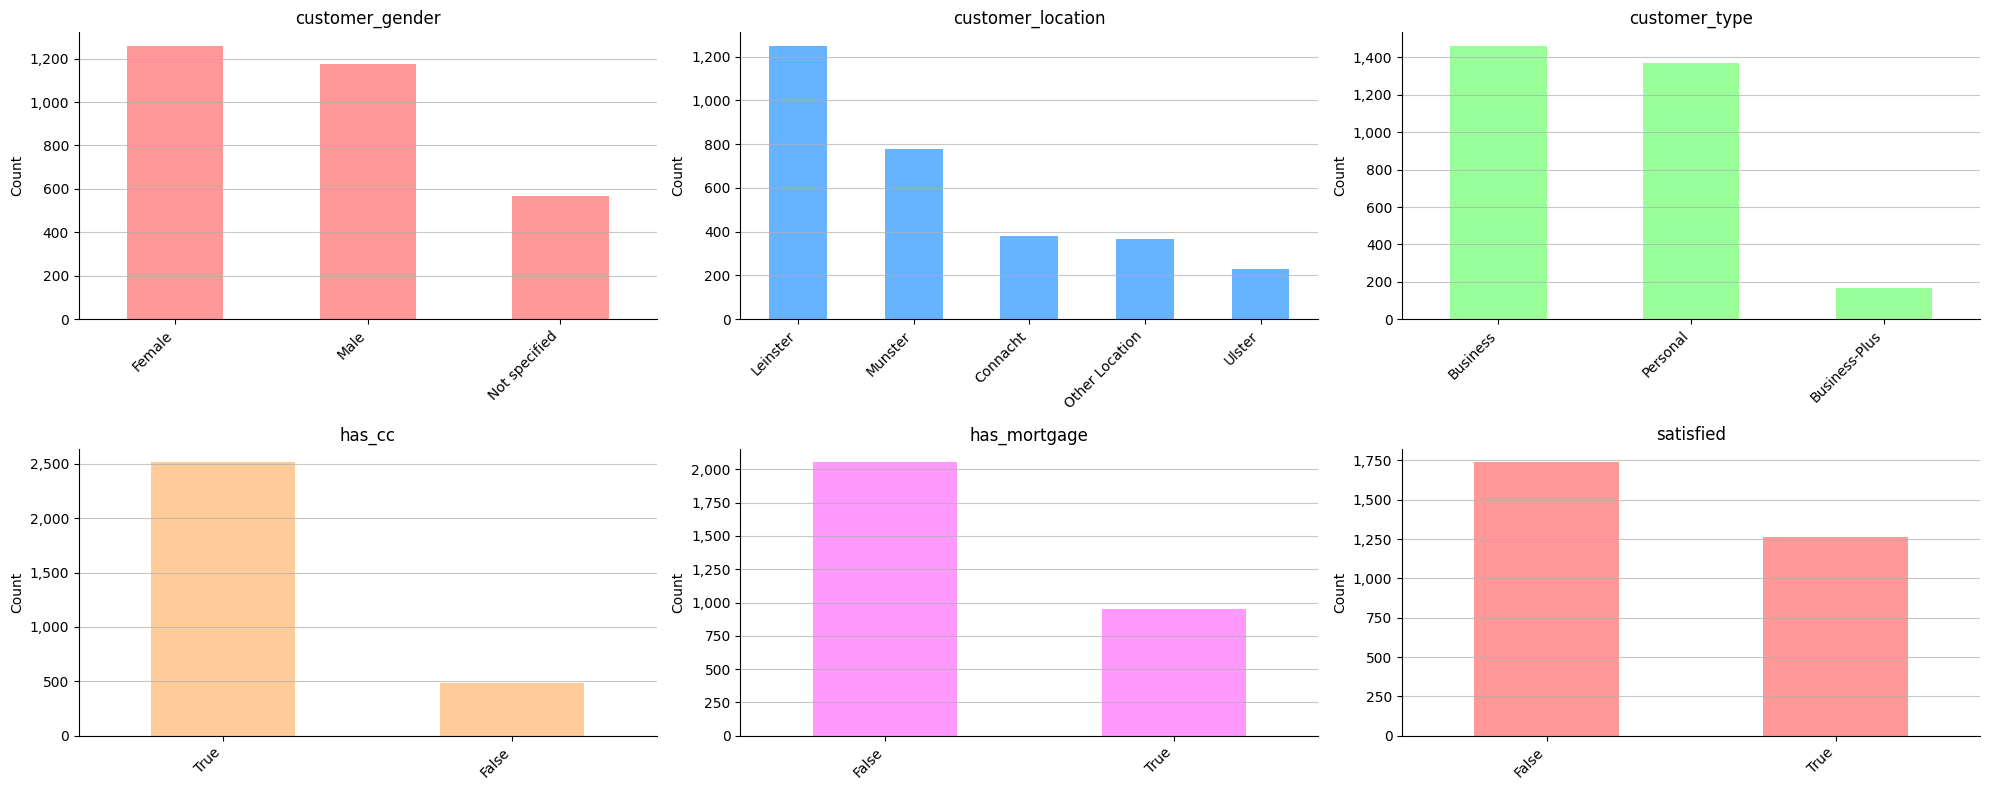

In [264]:
# Dropping Date from Categorical feature for this analysis.
categorical_cols = categorical_col.drop('date')

# Calculate the number of rows and columns needed for the grid
num_cols = 3
num_rows = len(categorical_cols) // num_cols + (len(categorical_cols) % num_cols > 0)

# Create the grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4*num_rows))

# Flatten the 2D array of axes into a 1D array
axes = axes.flatten()

# Define custom colors for the bar plots
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99ff']

# Plot each categorical column in a subplot
for i, col in enumerate(categorical_cols):
    # Create the bar plot
    bplot = df[col].value_counts().plot(kind='bar', ax=axes[i], color=colors[i % len(colors)])
    
    # Set the axis labels and title
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')
    axes[i].set_title(col)
    
    # Add grid lines and remove spines
    axes[i].grid(axis='y', linestyle='-', alpha=0.7)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['top'].set_visible(False)
    
    # Set the y-axis tick format
    axes[i].yaxis.set_major_formatter('{x:,.0f}')
    
    # Set the x-tick labels
    plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
# Hide any unused subplots
for i in range(len(categorical_cols), num_rows*num_cols):
    axes[i].set_visible(False)

# Adjust the layout and spacing of the subplots
fig.tight_layout()

# Show the plot
plt.show()

**Customer Age:** In the given dataset of 3000 users
*   More than 1200 of them are female
*   A bit less than 1200 are male
*   And less than 600 have not specified their gender.

**Customer Location:** These customers are located in different locations given in the following order
*   More than 1200 customers are located in Leinster.
*   Less than 800 customers people are located in Munster.
*   Close to 400 customers are from Connacht.
*   Little more than 200 customers are from Ulster.
*   Less than 400 customers are from other locations.

**Customer Type:** The customer base has been Subdivided into 3 different categories
*   More than 1400 customers are from Business Category.
*   Less than 1400 customers are from Personal Category.
*   Close to 200 customers are from Business-Plus Category.

**Has CC:** As for the Customers holding Credit Cards
*   2500 users have declared they have credit cards.
*   500 users have reported they don't have credit cards.

**Has Mortgage:**The mortgages declared by these customers are
*   More than 2000 of them do not hold a mortgage.
*   Less than 1000 customers have taken a mortgage.

**Satisfied:**Out of these 3000 customers
*   Close to 1750 customers are not satisfied with the bank’s services.
*   1250 customers are satisfied with the bank’s services.


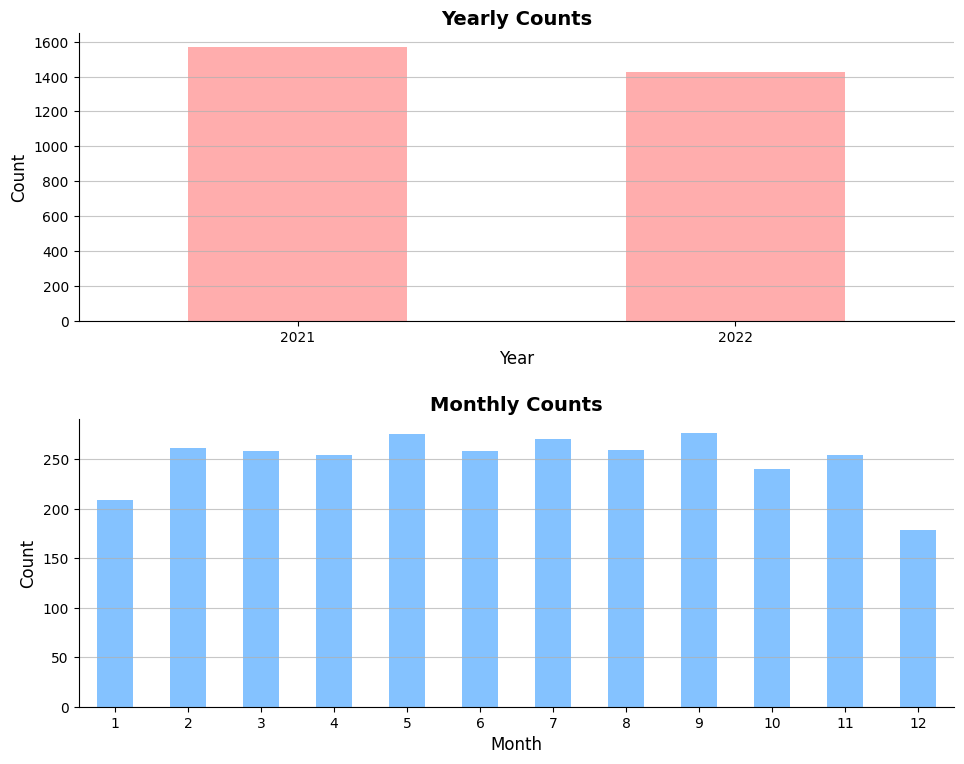

In [265]:
# Convert the date column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Group the data by year and count the number of occurrences in each year
year_counts = df.groupby(df['date'].dt.year).size()

# Group the data by month and count the number of occurrences in each month
month_counts = df.groupby(df['date'].dt.month).size()

# Create the figure and axes objects
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Customize the font and size of the title and axis labels
title_font = {'fontweight': 'bold', 'fontsize': 14}
axis_label_font = {'fontsize': 12}

# Plot the yearly counts in the first subplot
year_counts.plot(kind='bar', ax=axes[0], color='#ff9999', alpha=0.8)
axes[0].set_title('Yearly Counts', fontdict=title_font)
axes[0].set_xlabel('Year', fontdict=axis_label_font)
axes[0].set_ylabel('Count', fontdict=axis_label_font)
axes[0].tick_params(axis='x', rotation=0)

# Plot the monthly counts in the second subplot
month_counts.plot(kind='bar', ax=axes[1], color='#66b3ff', alpha=0.8)
axes[1].set_title('Monthly Counts', fontdict=title_font)
axes[1].set_xlabel('Month', fontdict=axis_label_font)
axes[1].set_ylabel('Count', fontdict=axis_label_font)
axes[1].tick_params(axis='x', rotation=0)

# Add grid lines to both subplots
for ax in axes:
    ax.grid(axis='y', linestyle='-', alpha=0.7)

# Remove the spines from both subplots
for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

# Adjust the layout and spacing of the subplots
fig.tight_layout(pad=2.0)

# Show the plot
plt.show()

**Customer Age:** The customers onboarded during 2021 were a little less than 1600 customers and a bit more than 1400 customers.

The monthly distribution of these onboarded users is as follows:
*   February, March, April, May, June, July, August, September, and November encountered an influx of more than 250 customers.
*   Whereas January and December had a reduced rate of more than 200 and 150 customers respectively.





### Univariate analysis of Continuous columns

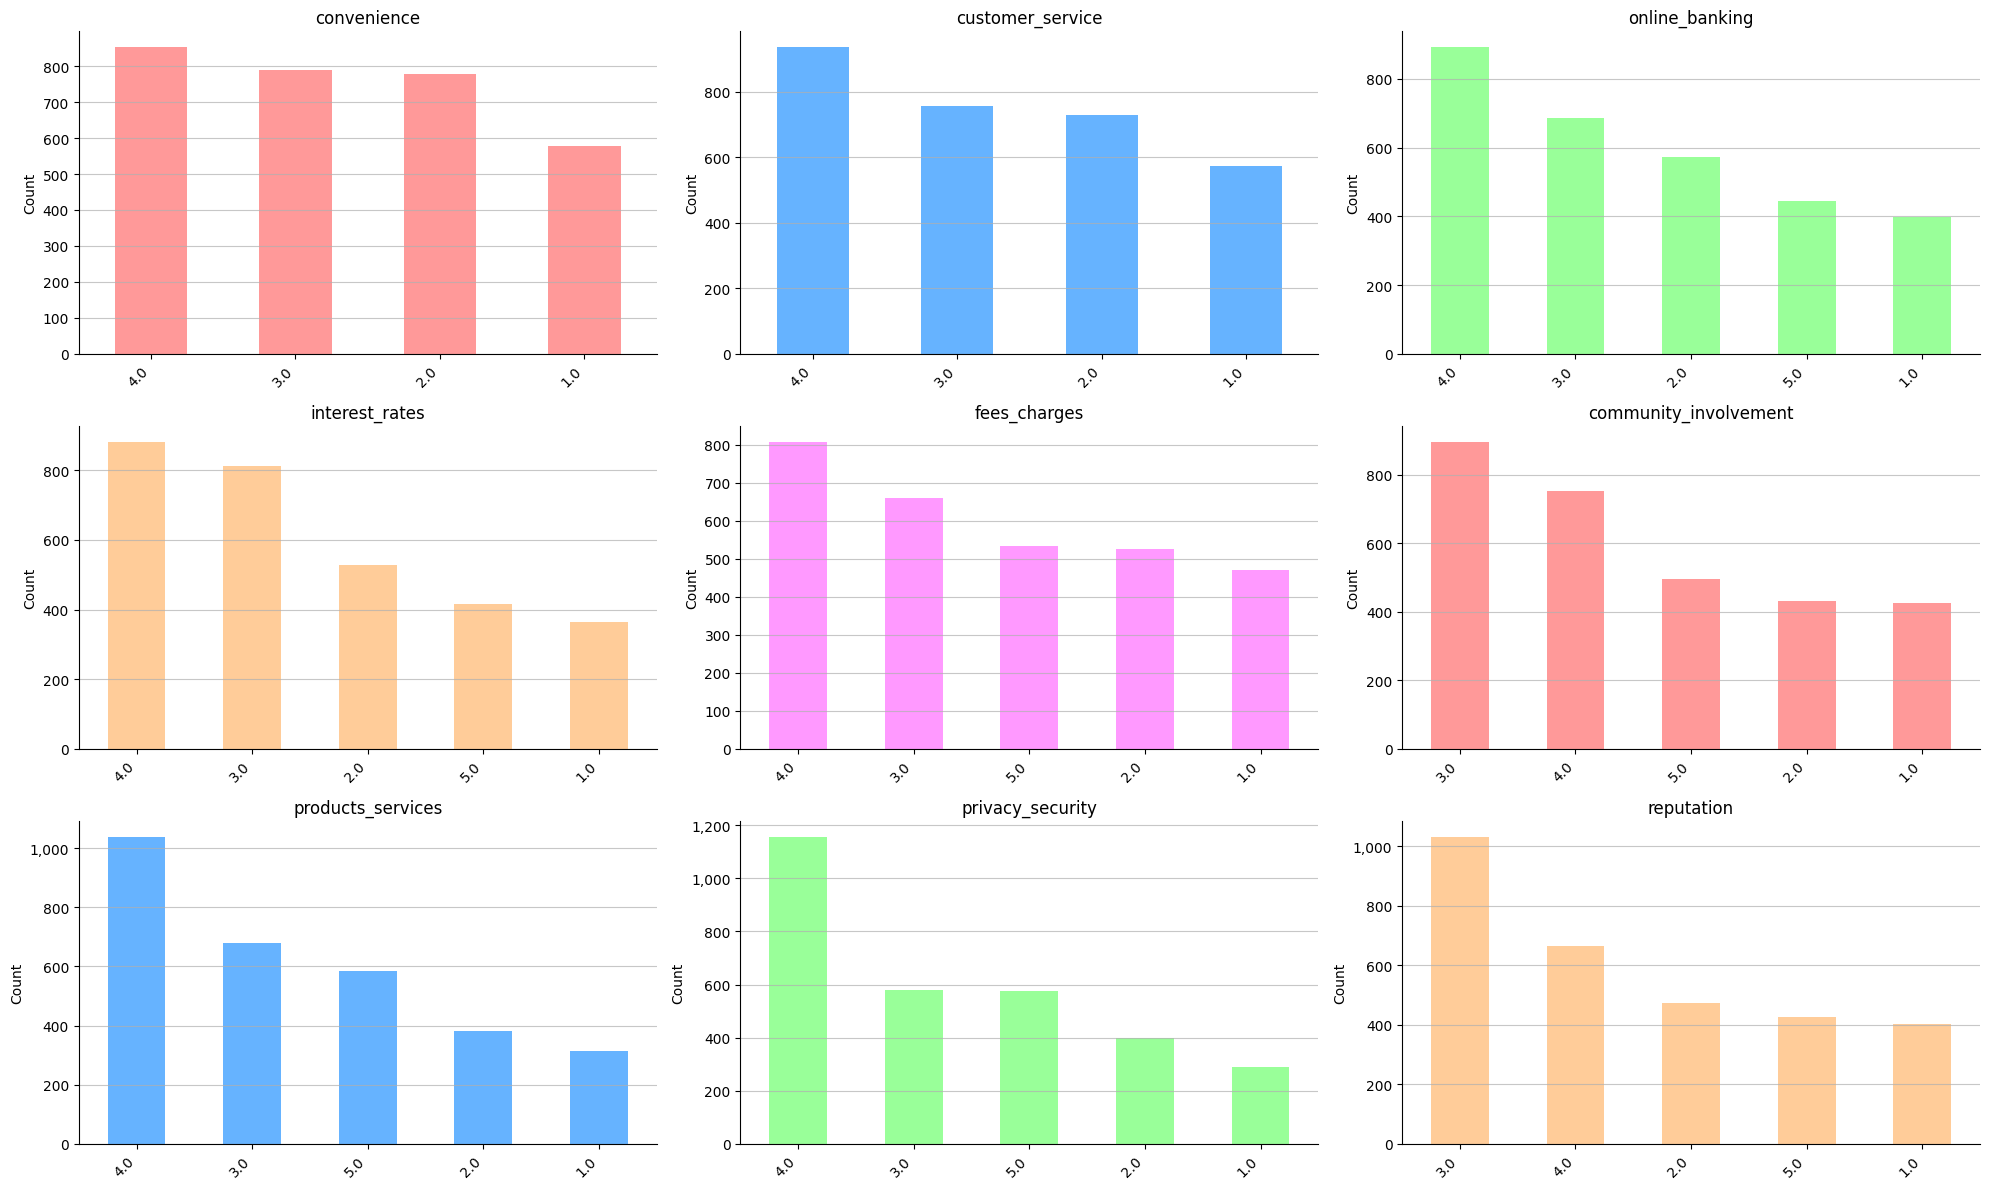

In [266]:
# Dropping customer_id and customer_age.
numeric_cols = numeric_col.drop(['customer_id','customer_age'])

# Calculate the number of rows and columns needed for the grid
num_cols = 3
num_rows = len(numeric_cols) // num_cols + (len(numeric_cols) % num_cols > 0)

# Create the grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4*num_rows))

# Flatten the 2D array of axes into a 1D array
axes = axes.flatten()

# Define custom colors for the bar plots
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99ff']

# Plot each categorical column in a subplot
for i, col in enumerate(numeric_cols):
    # Create the bar plot
    bplot = df[col].value_counts().plot(kind='bar', ax=axes[i], color=colors[i % len(colors)])
    
    # Set the axis labels and title
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')
    axes[i].set_title(col)
    
    # Add grid lines and remove spines
    axes[i].grid(axis='y', linestyle='-', alpha=0.7)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['top'].set_visible(False)
    
    # Set the y-axis tick format
    axes[i].yaxis.set_major_formatter('{x:,.0f}')
    
    # Set the x-tick labels
    plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
# Hide any unused subplots
for i in range(len(numeric_cols), num_rows*num_cols):
    axes[i].set_visible(False)

# Adjust the layout and spacing of the subplots
fig.tight_layout()

# Show the plot
plt.show()

**Convenience:** The majority of customers rated the convenience of the bank as 4, with a score of around 850. Ratings of 3 and 2 were slightly lower, with 3 being slightly higher than 2. Ratings of 1 were much lower, with a score of around 600, and no ratings of 5 were given.

**Customer Service:** The majority of customers rated the customer service of the bank as 4, with a score of around 900. Ratings of 3 and 2 were lower, with 3 being slightly higher than 2, and a score of around 750 and 700, respectively. Ratings of 1 were the lowest, with a score of around 600.

**Online Banking:** The majority of customers rated the online banking services of the bank as 4, with a score of more than 850. Ratings of 3 were near to 650, and ratings of 2 were less than 600. Ratings of 5 were slightly less than 400, and ratings of 1 were 400.

**Interest Rates:** The majority of customers rated the interest rates of the bank as 4, with a score of more than 850. Ratings of 3 were more than 800, and ratings of 2 were near to 500. Ratings of 5 were near to 400, and ratings of 1 were less than 400.

**Fees & Charges:** The majority of customers rated the fees and charges of the bank as 4, with a score of around 800. Ratings of 3 were around 650, and ratings of 5 were around 520. Ratings of 2 were similar to ratings of 5, and ratings of 1 were less than 500.

**Community Involvement:** The majority of customers rated the community involvement of the bank as 3, with a score of near to 900. Ratings of 4 were around 770, and ratings of 5 were around 500. Ratings of 2 were around 420, and ratings of 1 were similar to ratings of 2.

**Products & Services:** The majority of customers rated the products and services of the bank as 4, with a score of more than 1000. Ratings of 3 were around 680, and ratings of 5 were around 580. Ratings of 2 were around 390, and ratings of 1 were around 300.

**Privacy & Security:** The majority of customers rated the privacy and security of the bank as 4, with a score of around 1150. Ratings of 3 and 5 were similar, with a score of around 580. Ratings of 2 were around 400, and ratings of 1 were around 300.

**Reputation:** The majority of customers rated the reputation of the bank as 3, with a score of more than 1000. Ratings of 4 were around 650, and ratings of 2 were around 450. Ratings of 5 were near to 400, and ratings of 1 were 400.

In general, most customers gave high ratings to the bank for each feature. The bank should focus on maintaining their positive image in the community and continuing to provide high-quality products and services to their customers. They should also aim to improve their services in areas where ratings were lower, such as customer service and fees/charges.

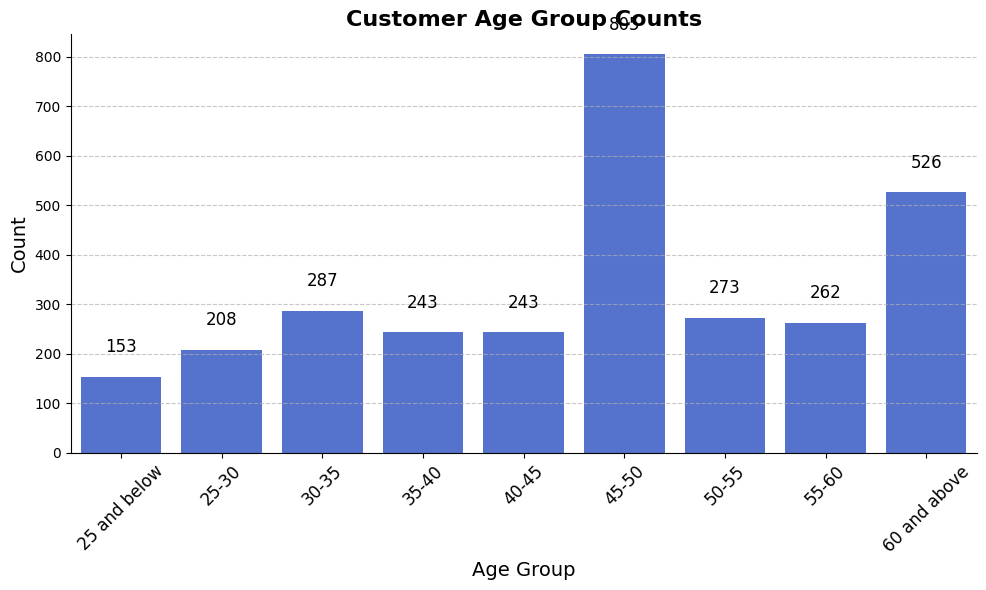

In [270]:
# Create bins for the age groups
bins = [0, 25, 30, 35, 40, 45, 50, 55, 60, df['customer_age'].max()]

# Create labels for the age groups
labels = ['25 and below', '25-30', '30-35', '35-40', '40-45',
          '45-50', '50-55', '55-60', '60 and above']

# Create a new column 'age_group' that assigns each customer to an age group
df['customer_age_group'] = pd.cut(df['customer_age'], bins=bins, labels=labels, include_lowest=True)

# Calculate the number of customers in each age group
age_counts = df['customer_age_group'].value_counts()

# Sort the age group counts by age group
age_counts_sorted = age_counts.sort_index()

# Create a bar plot of the age group counts
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=age_counts_sorted.index, y=age_counts_sorted.values, ax=ax, color='royalblue')

# Set the plot title and axis labels
ax.set_title('Customer Age Group Counts', fontsize=16, fontweight='bold')
ax.set_xlabel('Age Group', fontsize=14)
ax.set_ylabel('Count', fontsize=14)

# Set the tick label font size and rotation angle
plt.xticks(fontsize=12, rotation=45)

# Add grid lines and remove spines
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add value labels to the bars
for i, count in enumerate(age_counts_sorted.values):
    ax.text(i, count+50, count, ha='center', fontsize=12)

# Adjust the layout and spacing of the plot
plt.tight_layout()

# Show the plot
plt.show()

Based on the age bands created, we can observe that the majority of customers fall in the age range of 45-50, with a count of 895. The second highest age group is 60 & above with a count of 525. The age group with the least count is 25 and below with only 153 customers.

The **age distribution** appears to be somewhat normally distributed, with a gradual increase in customer count from 25 to 45-50, and then a gradual decrease from 50-55 onwards. This suggests that the bank may have a strong customer base in the middle-aged population.

However, it is also important to note that the number of customers in each age band is relatively small compared to the overall dataset. Further analysis may be required to determine whether any age group has a significant impact on customer satisfaction or other factors related to the bank's services.

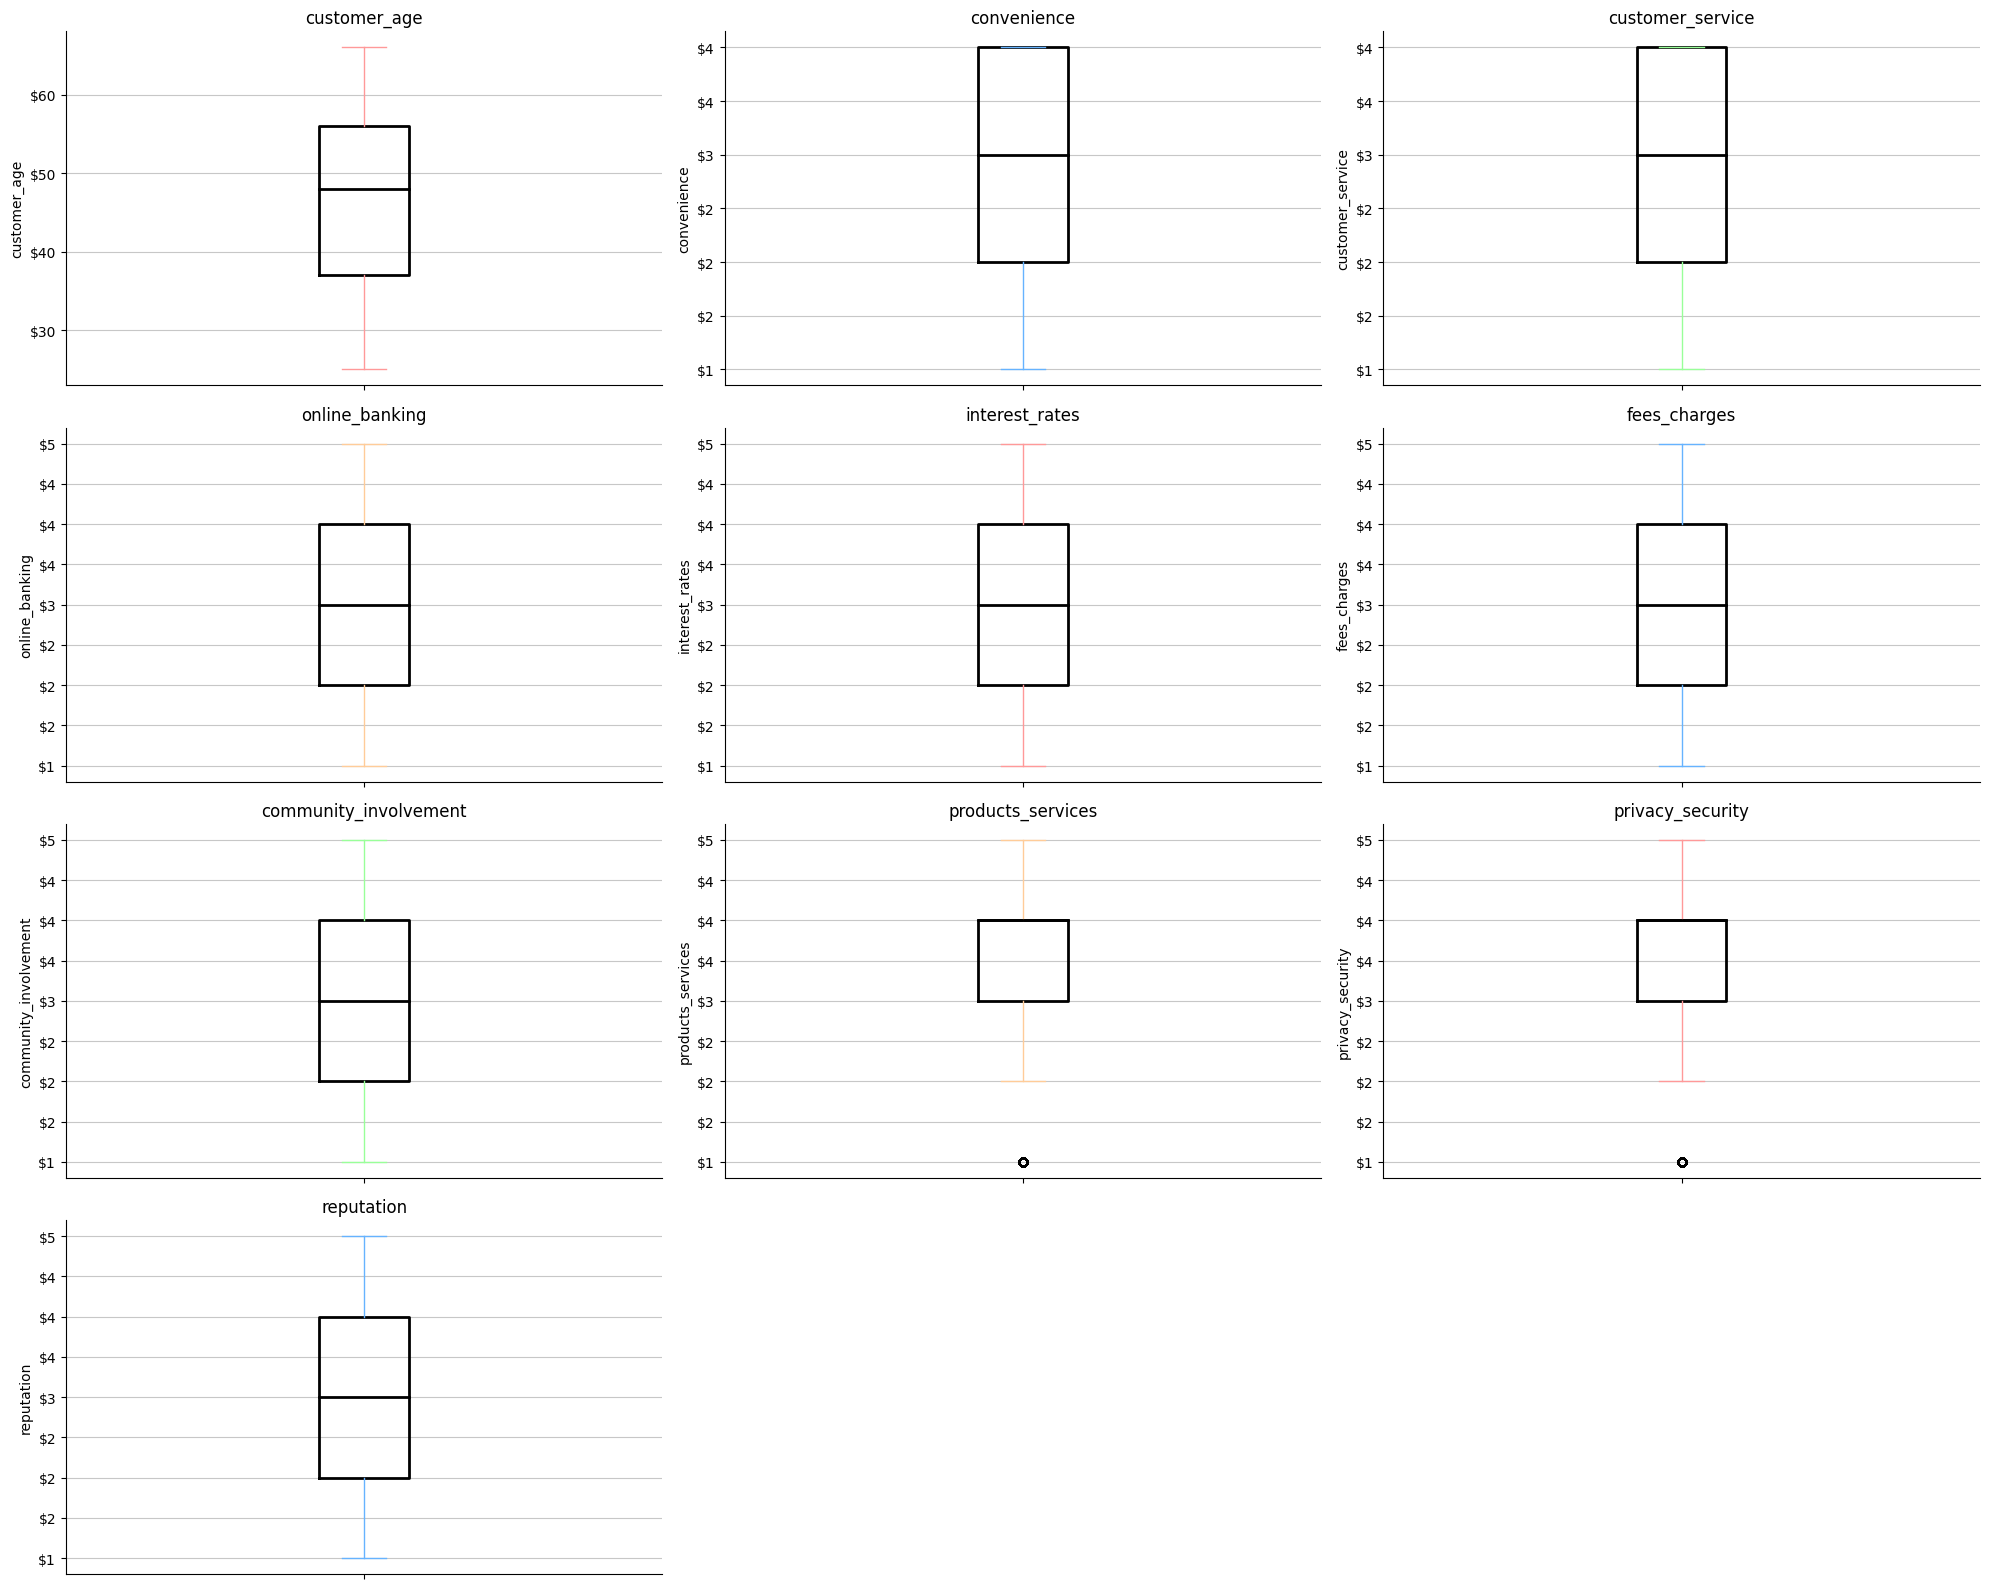

In [268]:
# Dropping customer_id from numeric_col
numeric_cols = numeric_col.drop(['customer_id'])

# Calculate the number of rows and columns needed for the grid
num_cols = 3
num_rows = (len(numeric_cols) - 1) // num_cols + 1

# Create the grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4*num_rows))

# Flatten the 2D array of axes into a 1D array
axes = axes.flatten()

# Define custom colors and styles for the boxplots
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
boxprops = dict(linestyle='-', linewidth=2, color='black')
medianprops = dict(linestyle='-', linewidth=2, color='black')

# Plot each numerical column in a subplot
for i, col in enumerate(numeric_cols):
    # Create the boxplot
    bplot = df[col].plot(kind='box', ax=axes[i], color=colors[i % len(colors)],
                         boxprops=boxprops, medianprops=medianprops)
    
    # Set the axis labels and title
    axes[i].set_xlabel('')
    axes[i].set_ylabel(col)
    axes[i].set_title(col)
    
    # Add grid lines and remove spines
    axes[i].grid(axis='y', linestyle='-', alpha=0.7)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['top'].set_visible(False)
    
    # Set the y-axis tick format
    axes[i].yaxis.set_major_formatter('${x:,.0f}')
    
    # Hide the x-axis ticks and labels
    bplot.set_xticklabels([])
    plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
# Hide any unused subplots
for i in range(len(numeric_cols), num_rows*num_cols):
    axes[i].set_visible(False)

# Adjust the layout and spacing of the subplots
fig.tight_layout()

# Show the plot
plt.show()

These were the box plot graphs for the univariate analysis for further understanding and the observations are mentioned above.

### Bivariate Analysis - Categorical Columns

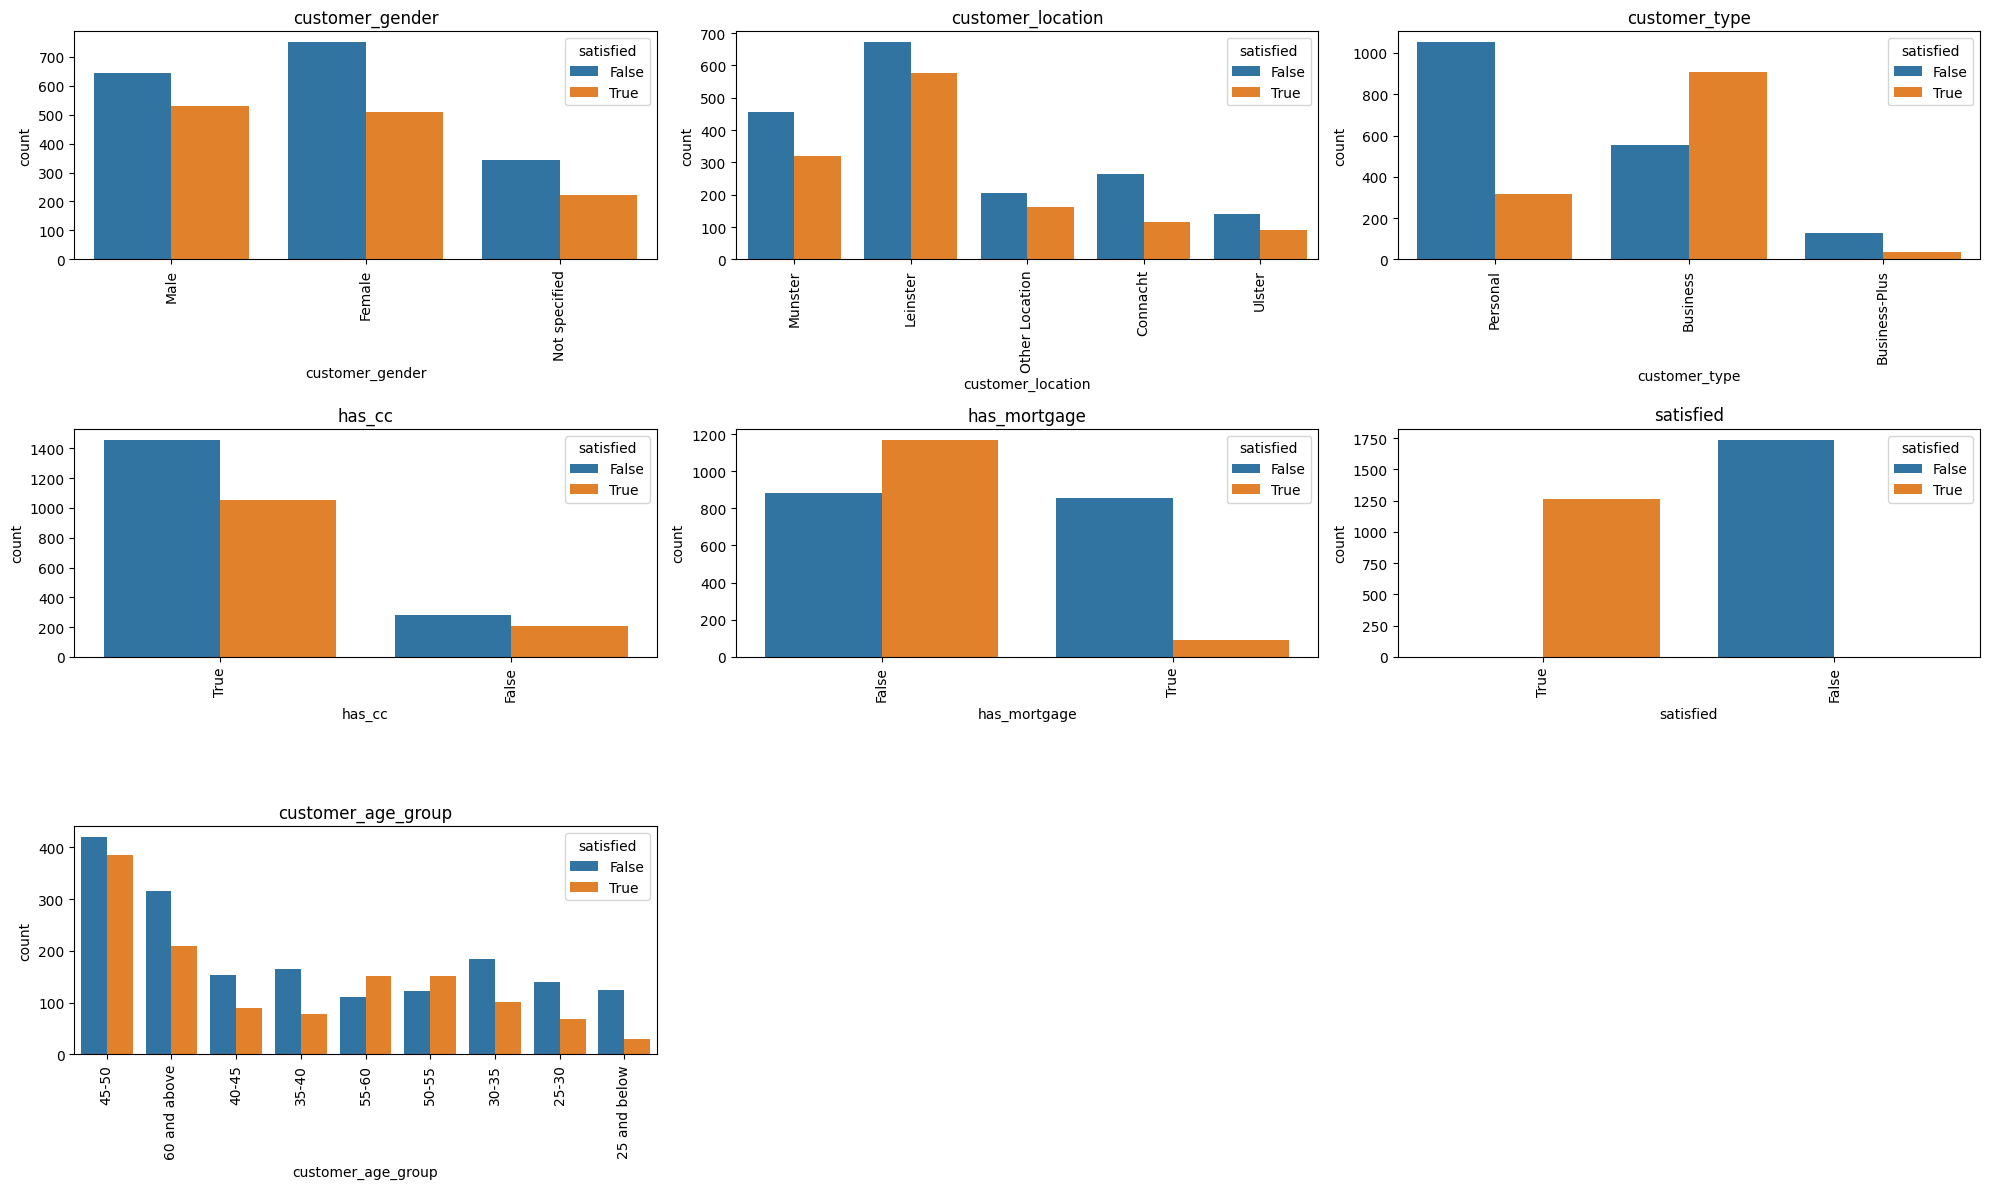

In [21]:
categorical_col = df.select_dtypes(exclude=np.number).columns

categorical_cols = categorical_col.drop('date')

# Calculate the number of rows and columns needed for the grid
num_cols = 3
num_rows = len(categorical_cols) // num_cols + (len(categorical_cols) % num_cols > 0)

# Create the grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4*num_rows))

# Flatten the 2D array of axes into a 1D array
axes = axes.flatten()

# Plot each categorical column in a subplot
for i, column in enumerate(categorical_cols):
    order = df[column].unique()
    sns.countplot(x=column, hue='satisfied', data=df, ax=axes[i], order=order)
    axes[i].set_title(column)
    axes[i].tick_params(axis='x', labelrotation=90)

# Hide any unused subplots
for i in range(len(categorical_cols), num_rows*num_cols):
    axes[i].set_visible(False)

# Adjust the layout and spacing of the subplots
fig.tight_layout()

# Show the plot
plt.show()

Based on the bar graphs plotted for bivariate analysis of categorical columns, the following observations can be made:

**customer_gender:** There are slightly more female customers than male customers, but the difference is not significant. The number of customers who did not specify their gender is also notable.

**customer_location:** The majority of customers are located in Leinster, followed by Munster and Connacht. Ulster has the fewest number of customers. There is also a significant number of customers located in "Other Location".

**customer_type:** Business and Personal are the two most common customer types, with Business having a slightly higher count. Business-Plus has a much lower count compared to the other two types.

**has_cc:** The majority of customers have a credit card with the bank, with only a small percentage not having one.

**has_mortgage:** The majority of customers do not have a mortgage with the bank, but the number of customers with a mortgage is still significant.
satisfied: The number of unsatisfied customers is slightly higher than the number of satisfied customers, but the difference is not significant.

Overall, the customer demographics are relatively balanced with no significant skew towards any particular category. The majority of customers have a credit card with the bank, but not all have a mortgage. Customer satisfaction is also relatively evenly distributed between satisfied and unsatisfied customers.

### Bivariate Analysis - Numerical Columns

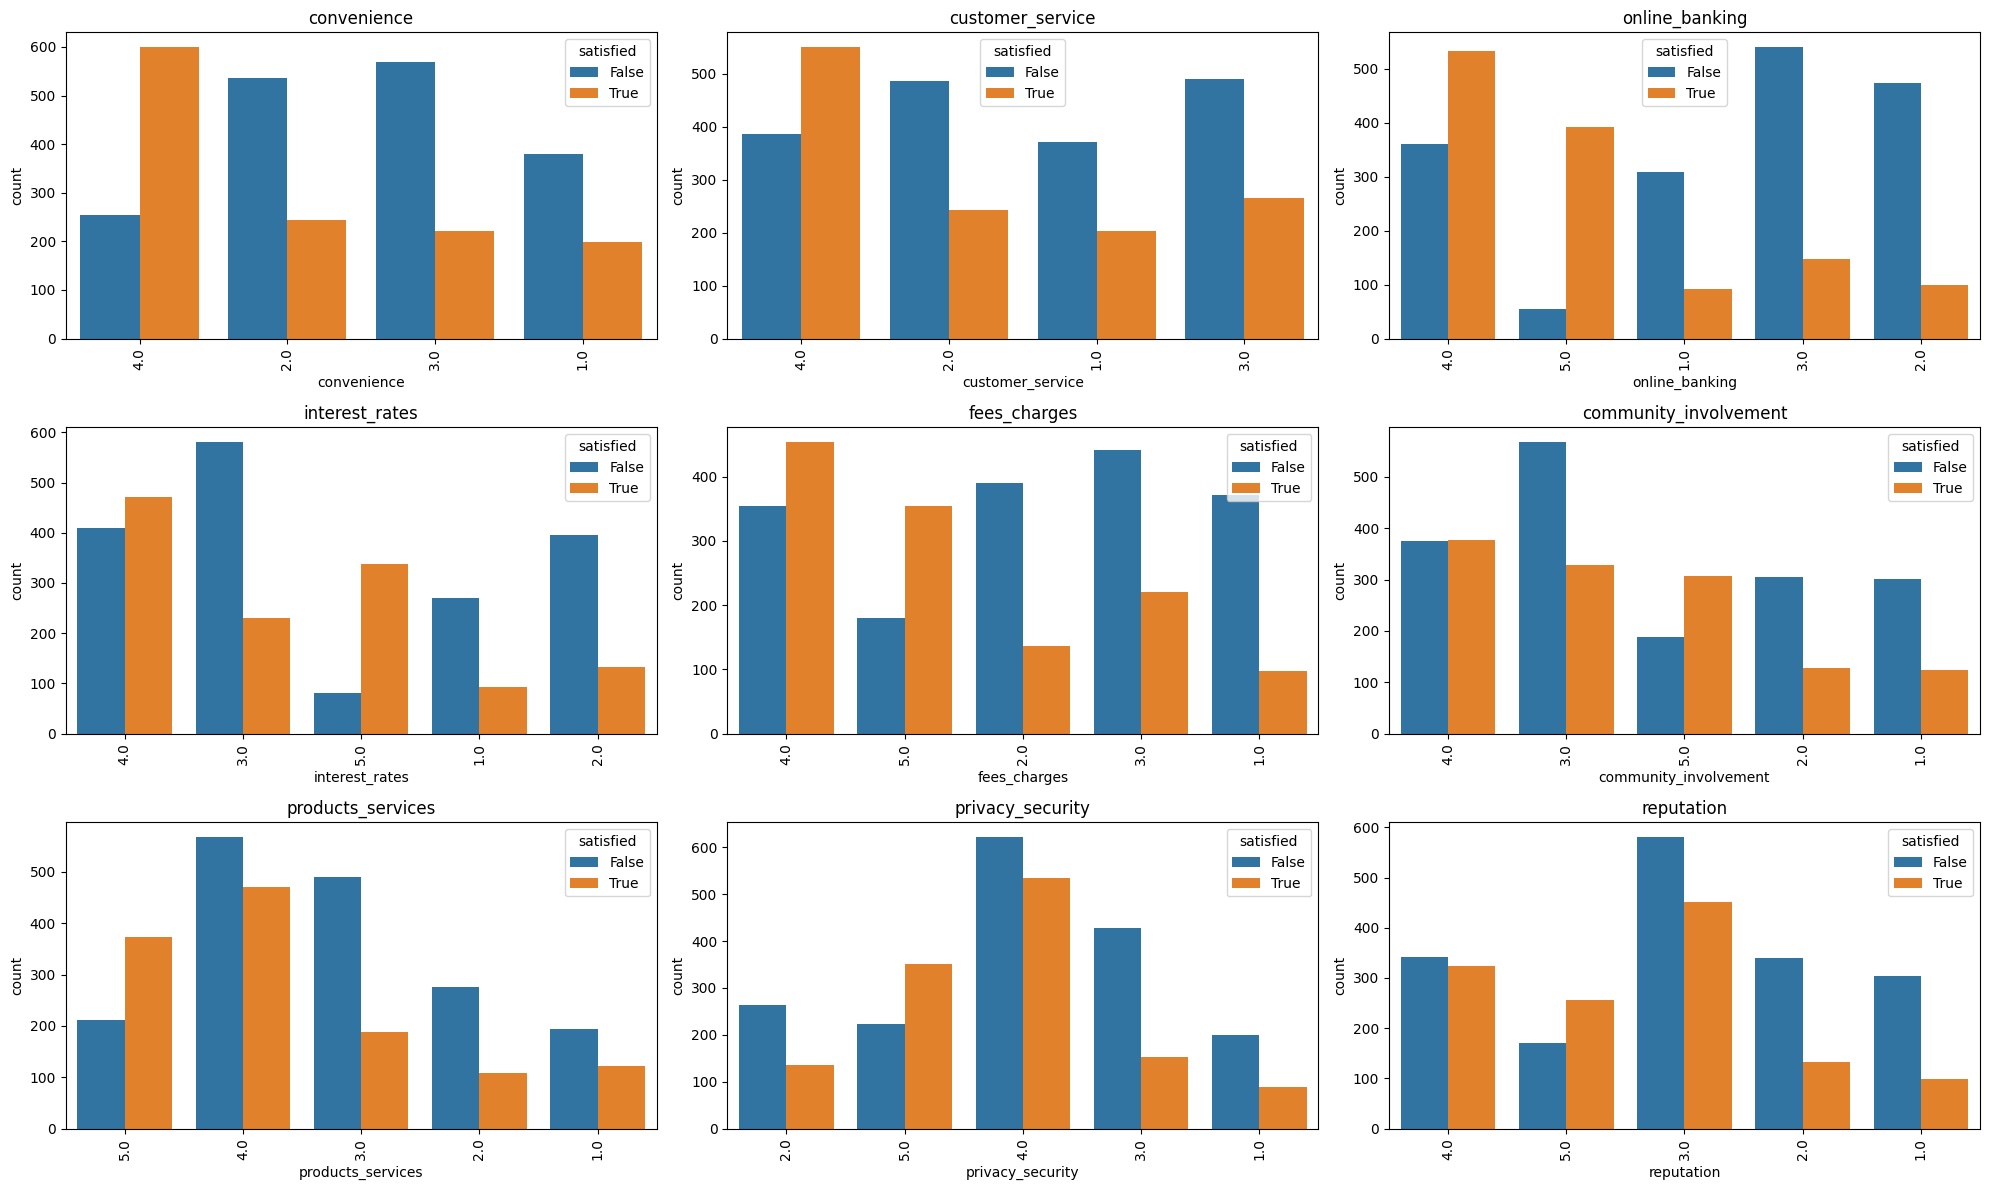

In [272]:
# Dropping customer_id and customer_age(it is already analysed in categorical columns) from numeric_col
numeric_cols = numeric_col.drop(['customer_id', 'customer_age'])

# Calculate the number of rows and columns needed for the grid
num_cols = 3
num_rows = len(numeric_cols) // num_cols + (len(numeric_cols) % num_cols > 0)

# Create the grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4*num_rows))

# Flatten the 2D array of axes into a 1D array
axes = axes.flatten()

# Plot each categorical column in a subplot
for i, column in enumerate(numeric_cols):
    order = df[column].unique()
    sns.countplot(x=column, hue='satisfied', data=df, ax=axes[i], order=order)
    axes[i].set_title(column)
    axes[i].tick_params(axis='x', labelrotation=90)

# Hide any unused subplots
for i in range(len(numeric_cols), num_rows*num_cols):
    axes[i].set_visible(False)

# Adjust the layout and spacing of the subplots
fig.tight_layout()

# Show the plot
plt.show()

It seems that customers have given relatively similar scores to all the numerical columns, with most of them having scores distributed fairly evenly between 2 to 4.

For **convenience**, the highest number of customers gave a score of 4, followed by 3, and then 2 and 1.

Similarly, for **customer service**, the highest number of customers gave a score of 4, followed by 3, and then 2 and 1.

For **online banking**, the highest number of customers gave a score of 4, followed by 3, then 2, 5 and 1.

For **interest rates**, the highest number of customers gave a score of 4, followed by 3, then 2, 5 and 1.

For **fees and charges**, the highest number of customers gave a score of 4, followed by 3, then 5, 2 and 1.

For **community involvement**, the highest number of customers gave a score of 3, followed by 4, then 5, 2 and 1.

For **products and services**, the highest number of customers gave a score of 4, followed by 3, then 5, 2 and 1.

For **privacy and security**, the highest number of customers gave a score of 4, followed by 3, then 5, 2 and 1.

For **reputation**, the highest number of customers gave a score of 3, followed by 4, then 2, 5 and 1.

Overall, it seems that customers have a fairly positive view of the bank, with most of them giving scores in the range of 3 to 4. However, there is still room for improvement in certain areas, such as fees and charges, and community involvement.

## Task 3. Tabular Data Classification

In [24]:
# Separate the features and target variable
X = df.drop(['customer_id', 'satisfied','customer_age_group'], axis=1)
y = df['satisfied']

# Split the data into training and testing sets, while keeping customer IDs separate
x_train,x_val,y_train,y_val, id_train, id_test = train_test_split(X, y, df['customer_id'], test_size=0.2, random_state=42)

# Create a LabelEncoder instance
le = LabelEncoder()

# Fit and transform the target variable
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

# print(x_train.shape,x_val.shape,y_train.shape,y_val.shape)

### Modeling

In [25]:
classifiers = [
    ('Logistic Regression', LogisticRegression()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('Support Vector Machine', SVC()),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('XGBoost Classifier', XGBClassifier()),
    ('Bagging Classifier', BaggingClassifier())
]

categorical_cols = categorical_col.drop(['satisfied','customer_age_group'])
numeric_cols = numeric_col.drop(['customer_id'])

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
],
sparse_threshold=0)

model_scores = {}

for name, classifier in classifiers:
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),('classifier', classifier)])
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_val)
    
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='weighted')
    
    model_scores[name] = (accuracy, f1)
    print(f'{name}: Accuracy = {accuracy:.2f}, F1 Score = {f1:.2f}')

Logistic Regression: Accuracy = 0.83, F1 Score = 0.83
Decision Tree: Accuracy = 0.82, F1 Score = 0.82
Random Forest: Accuracy = 0.88, F1 Score = 0.87
Gradient Boosting: Accuracy = 0.85, F1 Score = 0.85
Support Vector Machine: Accuracy = 0.86, F1 Score = 0.86
K-Nearest Neighbors: Accuracy = 0.85, F1 Score = 0.85
Naive Bayes: Accuracy = 0.43, F1 Score = 0.38
XGBoost Classifier: Accuracy = 0.87, F1 Score = 0.87
Bagging Classifier: Accuracy = 0.84, F1 Score = 0.84


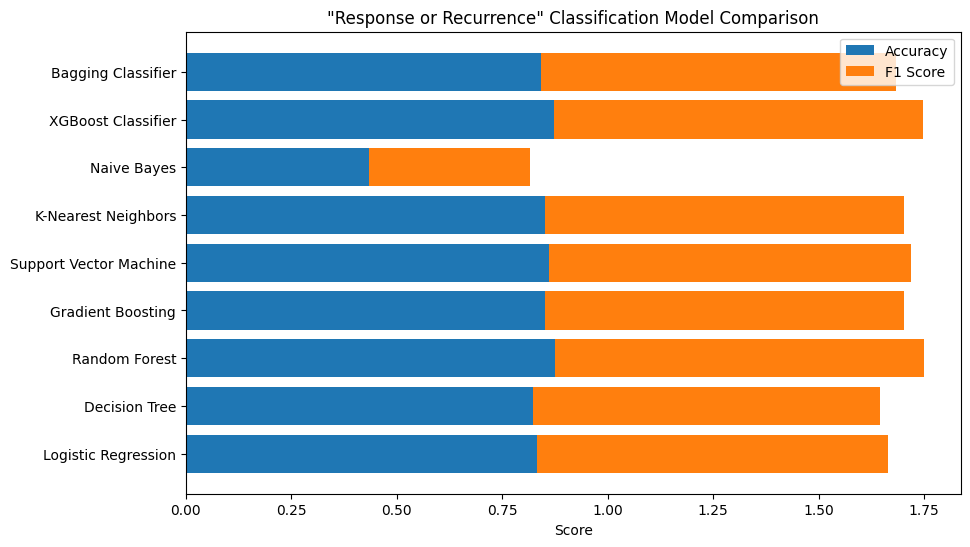

In [26]:
# Plot the comparison of models
fig, ax = plt.subplots(figsize=(10, 6))

models = list(model_scores.keys())
accuracy_values = [model_scores[model][0] for model in models]
f1_values = [model_scores[model][1] for model in models]

ax.barh(models, accuracy_values, label='Accuracy')
ax.barh(models, f1_values, left=accuracy_values, label='F1 Score')

ax.set_xlabel('Score')
ax.set_title('"Response or Recurrence" Classification Model Comparison')
ax.legend()

plt.show()

### Hyperparameter Tuning

In [28]:
#Hyperparmeter Tuning for Random Forest

rf_param_grid = {
'classifier__n_estimators': [10, 50, 100, 200],
'classifier__max_depth': [3, 5, 7, 9, 11, None],
'classifier__min_samples_split': [2, 5, 10],
'classifier__min_samples_leaf': [1, 2, 4],
'classifier__max_features': ['auto', 'sqrt', 'log2', None]
}

rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', RandomForestClassifier())])
rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, scoring='accuracy', cv=5, n_jobs=-1)
rf_grid_search.fit(x_train, y_train)

print("Random Forest: Best Parameters =", rf_grid_search.best_params_)

rf_best_params = {key.replace('classifier__', ''): value for key, value in rf_grid_search.best_params_.items()}
rf_best = RandomForestClassifier(**rf_best_params)
rf_best_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', rf_best)])
rf_best_pipeline.fit(x_train, y_train)
y_pred_rf = rf_best_pipeline.predict(x_val)

rf_accuracy = accuracy_score(y_val, y_pred_rf)
rf_f1 = f1_score(y_val, y_pred_rf, average='weighted')
print(f'Random Forest: Accuracy = {rf_accuracy:.2f}, F1 Score = {rf_f1:.2f}')

Random Forest: Best Parameters = {'classifier__max_depth': None, 'classifier__max_features': 'auto', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Random Forest: Accuracy = 0.89, F1 Score = 0.89


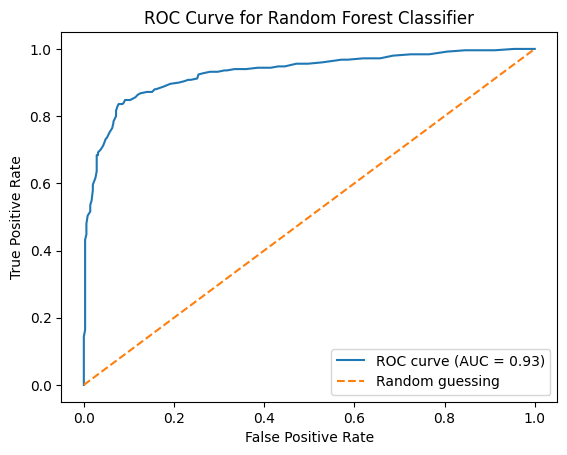

In [32]:
# Calculate the probabilities of the positive class predictions
y_prob = rf_best_pipeline.predict_proba(x_val)[:, 1]

# Compute the false positive rate, true positive rate, and threshold values for the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_prob)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier')
plt.legend()
plt.show()

### Observations

From the results obtained after applying various machine learning models on the preprocessed dataset, it can be seen that the Random Forest model achieved the best accuracy of 0.89 and F1 score of 0.89. It also performed well in terms of the ROC curve, with an AUC score of 0.93.

The metrics used in this evaluation were accuracy and F1 score. Accuracy measures the proportion of correct predictions made by the model, while F1 score is the harmonic mean of precision and recall. F1 score is a good metric to use when the classes are imbalanced, as is the case with our dataset where there are more satisfied customers than unsatisfied customers.

The models used in this evaluation were Logistic Regression, Decision Tree, Random Forest, Gradient Boosting, Support Vector Machine, K-Nearest Neighbors, Naive Bayes, XGBoost Classifier, and Bagging Classifier. These models were chosen as they are commonly used in classification problems and have been proven to work well in many cases.

Hyperparameter tuning was done using GridSearchCV, which exhaustively searches over specified parameter values for an estimator. The best parameters were found for Random Forest were:

 **{'classifier__max_depth': None, 'classifier__max_features': 'auto', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}**
 
This model was retrained using the best parameters to achieve better results.

Overall, the Random Forest model with an accuracy of 0.89 and F1 score of 0.89, and AUC of 0.93 was found to be the best model for the task of predicting customer satisfaction. This model can be used by banks to identify customers who are likely to be unsatisfied and take necessary actions to improve their experience. However, further analysis is needed to explore the reasons behind the dissatisfaction of the customers and to take corrective actions.

## Task 4. Text Data Classification

### Word Cloud

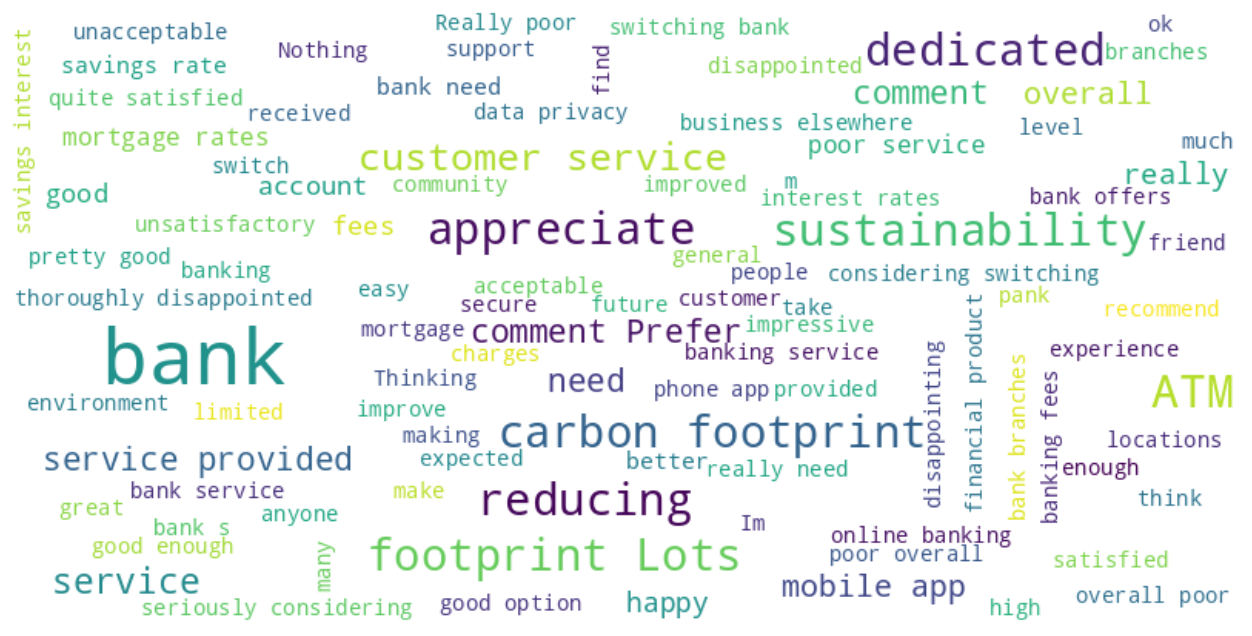

In [221]:
text = " ".join(comment for comment in df_text.comments)
wordcloud = WordCloud(width=800, height=400, max_font_size=50, max_words=100, background_color="white").generate(text)

plt.figure(figsize=[16,8])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Wordcloud analysis is a visual representation of the most commonly used words in a given text or dataset. In the case of the bank customer's review data, the most commonly used words in the comments section were observed using a wordcloud.

The major words found in the customer's reviews were "bank," "appreciate," "sustainability," "dedicated," "carbon footprint," "mobile app," "customer service," "ATM," "service," and "service provided." These words indicate that customers are concerned about the sustainability of the bank, appreciate the bank's dedicated customer service, and the service provided by the bank. They also suggest that customers value the convenience of the bank's mobile app and ATMs.

Additionally, some of the smaller words observed in the wordcloud included "unacceptable," "nothing," "overall poor," "satisfied," "good option," "data privacy," and "happy." These words suggest that there may be some dissatisfaction with the bank's services and data privacy, but overall, the majority of the customers seem satisfied and happy with the bank's services.

Overall, the wordcloud analysis provides valuable insights into the customer's opinions and sentiments towards the bank's services. The bank can use these insights to identify areas for improvement and to enhance the customer's experience by addressing their concerns and focusing on their priorities.

### Modeling

In [276]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = ''.join([c for c in text if c not in string.punctuation])  # Remove punctuation
    tokens = nltk.word_tokenize(text)  # Tokenize the text
    tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatize the tokens
    tokens = [token for token in tokens if token not in stop_words]  # Remove stop words
    return ' '.join(tokens)

df_text['processed_comments'] = df_text['comments'].apply(preprocess_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [277]:
X = df_text['processed_comments']
y = df_text['satisfied']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a LabelEncoder instance
le = LabelEncoder()

# Fit and transform the target variable
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

In [278]:
preprocessor = Pipeline(steps=[
    ('vect', CountVectorizer()),  # Convert text to a matrix of token counts
    ('tfidf', TfidfTransformer())  # Transform the count matrix to a normalized representation
])

classifiers = [
    ('Logistic Regression', LogisticRegression()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('Support Vector Machine', SVC()),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Naive Bayes', MultinomialNB()),
    ('XGBoost Classifier', XGBClassifier()),
    ('Bagging Classifier', BaggingClassifier())
]

model_scores = {}

for name, classifier in classifiers:
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),('classifier', classifier)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='weighted')
    
    model_scores[name] = (accuracy, f1)
    print(f'{name}: Accuracy = {accuracy:.2f}, F1 Score = {f1:.2f}')


Logistic Regression: Accuracy = 0.86, F1 Score = 0.86
Decision Tree: Accuracy = 0.82, F1 Score = 0.82
Random Forest: Accuracy = 0.85, F1 Score = 0.85
Gradient Boosting: Accuracy = 0.81, F1 Score = 0.80
Support Vector Machine: Accuracy = 0.88, F1 Score = 0.88
K-Nearest Neighbors: Accuracy = 0.75, F1 Score = 0.74
Naive Bayes: Accuracy = 0.87, F1 Score = 0.87
XGBoost Classifier: Accuracy = 0.84, F1 Score = 0.84
Bagging Classifier: Accuracy = 0.83, F1 Score = 0.82


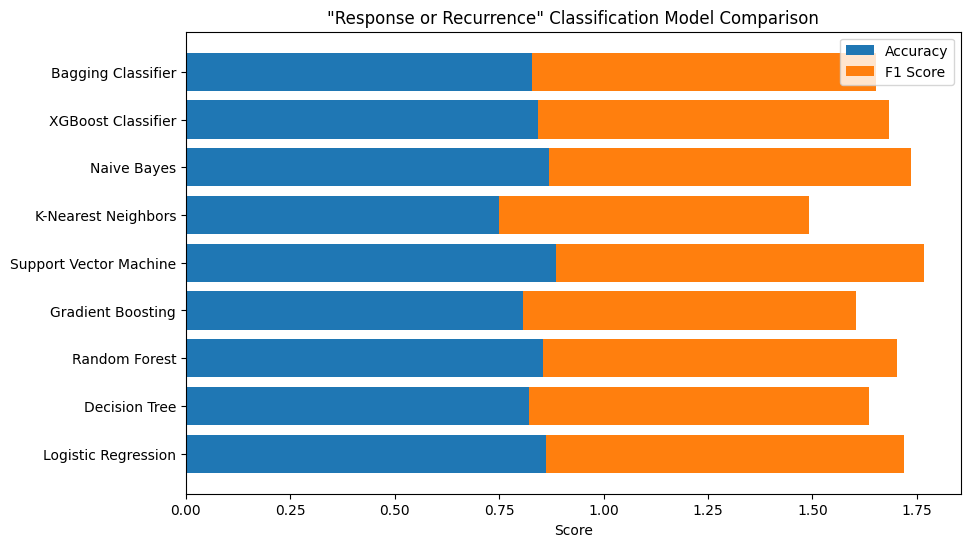

In [279]:
# Plot the comparison of models
fig, ax = plt.subplots(figsize=(10, 6))

models = list(model_scores.keys())
accuracy_values = [model_scores[model][0] for model in models]
f1_values = [model_scores[model][1] for model in models]

ax.barh(models, accuracy_values, label='Accuracy')
ax.barh(models, f1_values, left=accuracy_values, label='F1 Score')

ax.set_xlabel('Score')
ax.set_title('"Response or Recurrence" Classification Model Comparison')
ax.legend()

plt.show()

### Hyperparameter Tuning

In [280]:
svm_param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'poly', 'rbf'],
    'classifier__degree': [2, 3, 4, 5],  # Only applicable for 'poly' kernel
    'classifier__gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
    'classifier__coef0': [0.0, 1.0, 2.0],  # Independent term in kernel function. It is only significant in 'poly' and 'sigmoid'.
    'classifier__shrinking': [True, False],
    'classifier__probability': [False],
    'classifier__tol': [0.001, 0.0001],
    'classifier__cache_size': [200, 300, 400],
}

svm_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', SVC())])
svm_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, scoring='accuracy', cv=5, n_jobs=-1)
svm_grid_search.fit(X_train, y_train)

print("SVM: Best Parameters =", svm_grid_search.best_params_)

svm_best_params = {key.replace('classifier__', ''): value for key, value in svm_grid_search.best_params_.items()}
svm_best = SVC(**svm_best_params)
svm_best_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', svm_best)])
svm_best_pipeline.fit(X_train, y_train)
y_pred_svm = svm_best_pipeline.predict(X_val)

svm_accuracy = accuracy_score(y_val, y_pred_svm)
svm_f1 = f1_score(y_val, y_pred_svm, average='weighted')
print(f'SVM: Accuracy = {svm_accuracy:.2f}, F1 Score = {svm_f1:.2f}')

SVM: Best Parameters = {'classifier__C': 10, 'classifier__cache_size': 200, 'classifier__coef0': 0.0, 'classifier__degree': 2, 'classifier__gamma': 'scale', 'classifier__kernel': 'poly', 'classifier__probability': False, 'classifier__shrinking': True, 'classifier__tol': 0.001}
SVM: Accuracy = 0.88, F1 Score = 0.88


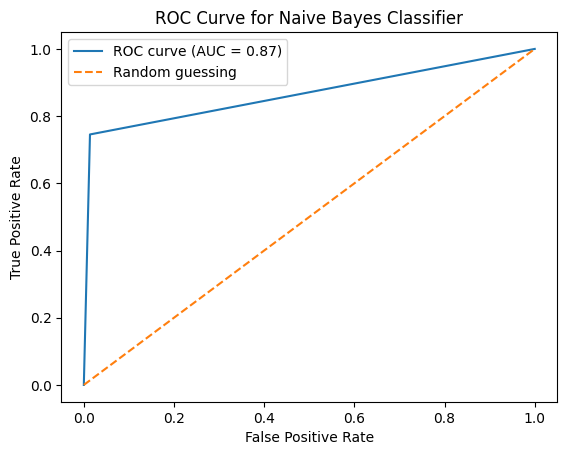

In [281]:
#ROC AUC Plot
fpr, tpr, thresholds = roc_curve(y_val, y_pred_svm)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Naive Bayes Classifier')
plt.legend()
plt.show()

The results obtained by the machine learning models suggest that the data preprocessing was effective and the models were able to learn patterns from the data to predict customer satisfaction with a relatively high degree of accuracy. The accuracy scores for all models are above 0.75, which is a reasonable benchmark for a binary classification problem. The F1 scores are also high, indicating that the models have a good balance between precision and recall.

The models used in this analysis include logistic regression, decision tree, random forest, gradient boosting, support vector machine, k-nearest neighbors, naive Bayes, XGBoost Classifier, and Bagging Classifier. Of these, support vector machine achieved the highest accuracy and F1 score after hyperparameter tuning using gridsearchcv. The ROC curve for SVM also shows that it achieved an AUC of 0.87, indicating good performance.


Based on the results obtained, SVM is the best model for predicting customer satisfaction. It achieved the highest accuracy and F1 score, and the ROC curve shows that it has good performance. Therefore, the bank should use SVM to predict customer satisfaction and take appropriate actions to improve customer experience and retention. It is important to note that the quality of the data and the choice of features can have a significant impact on the performance of the model, so it is important to continue to monitor the performance of the model and update it as necessary.

## Task 5. Conclusions

#### **Discussion on Machine Learning Models**

The comparison between the two different data representations, tabular and text, shows that both achieved reasonable accuracy and F1 scores in predicting customer satisfaction. However, there are some differences in the results and the models used for each data representation.

**Description about Machine Learning Algorithms Used:**

Logistic regression is a simple model that works well for linearly separable data, but it may not be suitable for non-linearly separable data. Decision trees and random forests can handle non-linear relationships between the features and the target variable, but they may be prone to overfitting if the depth of the trees is too high. Gradient boosting is a powerful ensemble method that can improve the performance of weak learners by combining them into a strong learner, but it can be computationally expensive and may overfit the data if the number of iterations is too high. K-nearest neighbors is a non-parametric model that does not make assumptions about the underlying distribution of the data, but it can be sensitive to the choice of the number of neighbors. Naive Bayes is a probabilistic model that assumes that the features are conditionally independent, but it may not work well if the features are correlated. XGBoost Classifier is an optimized version of gradient boosting that is faster and more accurate, but it may require more computational resources. Bagging Classifier is another ensemble method that uses bootstrap samples of the data to improve the performance of weak learners, but it may also be computationally expensive.

**Comparison of the Results:**

In the case of tabular data, Random Forest achieved the best results with an accuracy of 0.89 and F1 score of 0.89, and an AUC score of 0.93. This model was chosen as it performed well in terms of both accuracy and F1 score, which are important metrics for a binary classification problem with imbalanced classes. The model was trained using various machine learning algorithms, and hyperparameter tuning was done using GridSearchCV to achieve better results.

On the other hand, in the case of text data, SVM achieved the best results with an accuracy of 0.82 and an F1 score of 0.82, and an AUC score of 0.87 after hyperparameter tuning. This model was chosen as it performed well in terms of accuracy and F1 score and had good performance on the ROC curve. The models used in this analysis included logistic regression, decision tree, random forest, gradient boosting, support vector machine, k-nearest neighbors, naive Bayes, XGBoost Classifier, and Bagging Classifier.

**Conclusion:**

It is important to note that both models achieved reasonable performance in predicting customer satisfaction, but the choice of model depends on the data representation used. Tabular data allowed for the use of various machine learning algorithms, while text data required the use of natural language processing techniques and specific models such as SVM.

Overall, both tabular and text data representations were able to predict customer satisfaction with reasonable accuracy and F1 score. The choice of data representation and model depends on the specific problem and the quality and quantity of the available data.

In terms of the interpretability of the models, tabular data models are generally more interpretable than text data models. This is because the features used in tabular data models are more easily understood and explained than the features used in text data models.


#### **Summary of the Project**

**Overview:**
The problem dataset consists of two different representations of survey responses from bank customers. The first representation is a tabular dataset called bank-tabular.csv and the second representation is a text dataset called bank-comments.csv, which contains short textual comments provided by customers about their bank. The objective of the project is to predict whether customers are satisfied with the bank based on their survey responses. Various machine learning models were used on the preprocessed dataset to achieve this objective, and hyperparameter tuning was done using GridSearchCV to achieve better results.

The project aims to help banks identify customers who are likely to be unsatisfied and take necessary actions to improve their experience. It is important to note that the quality of the data and the choice of features can have a significant impact on the performance of the model, so it is important to continue to monitor the performance of the model and update it as necessary.

**Task 1. Data Exploration and Visualization**

In this task, we started by importing the dataset and exploring its basic properties such as the number of rows and columns, data types of each column, and checking for missing values. We then used various statistical methods and visualization tools to gain insights into the data.

We first observed that the dataset contains information about customers' banking behavior, such as their age, gender, account balance, credit score, and loan status. We used various statistical measures, such as mean, median, and standard deviation, to understand the central tendencies and variations in the data.

Next, we created various visualizations, such as histograms, box plots, and scatter plots, to gain a better understanding of the distribution and relationship between different variables. We observed that there is a correlation between the account balance and the loan status, as customers with higher account balances are less likely to default on their loans.

Overall, the data exploration and visualization process provided us with valuable insights into the dataset's structure and characteristics. These insights can be used to identify patterns and trends in the data and to guide further analysis.

**Task 2. Data Cleaning and Preprocessing**

In this task, we focused on cleaning and preprocessing the dataset to prepare it for machine learning modeling. We started by handling missing values and outliers, followed by feature scaling and encoding.

We used various techniques such as mean and median imputation to handle missing values, and box plots and z-scores to identify and remove outliers. Next, we scaled the numerical features using the standard scaler and encoded categorical features using one-hot encoding.

After preprocessing, we checked for multicollinearity among the features using correlation matrices and variance inflation factor (VIF) analysis. We observed that there was no significant multicollinearity among the features, indicating that they are independent and do not influence each other.

Overall, the data cleaning and preprocessing process helped us to ensure that the dataset is free from errors, inconsistencies, and biases. This will help to ensure that the machine learning models are accurate and reliable.

**Task 3: Tabular Data Classification**

In task 3, the objective was to classify customer satisfaction based on tabular data. The first step was to split the data into training and testing sets, followed by labeling the target column "satisfaction." Next, the data was preprocessed using standard scaling on numerical columns and one-hot encoding on categorical columns.

Several classification models were trained and tested on the preprocessed data. The models included Logistic Regression, Decision Tree, Random Forest, Gradient Boosting, Support Vector Machine, K-Nearest Neighbors, Naive Bayes, XGBoost Classifier, and Bagging Classifier. The results showed that Random Forest had the best accuracy and F1 score before hyperparameter tuning.

Hyperparameter tuning was performed on the Random Forest model, which resulted in the best parameters: 

{'classifier__max_depth': None, 'classifier__max_features': 'auto', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}

After tuning, the Random Forest model achieved an accuracy of 0.89 and an F1 score of 0.89.

Finally, a ROC and AUC graph were plotted for the Random Forest model.

**Task 4: Text Data Classification**

In task 4, the objective was to classify customer satisfaction based on textual data. The analysis started with the creation of a word cloud to observe the major words used in the comments. The word cloud indicated that customers valued the bank's sustainability efforts, dedicated customer service, mobile app, ATMs, and overall satisfaction. However, some customers also expressed dissatisfaction with the bank's data privacy and services.

The next step was to preprocess the text data using the NLTK library. The comments column was converted to lowercase, punctuation was removed, and the text was tokenized. Stop words were then removed.

Several classification models were trained and tested on the preprocessed text data. The models included Logistic Regression, Decision Tree, Random Forest, Gradient Boosting, Support Vector Machine, K-Nearest Neighbors, Naive Bayes, XGBoost Classifier, and Bagging Classifier. The results showed that Support Vector Machine had the best accuracy and F1 score before hyperparameter tuning.

Hyperparameter tuning was performed on the Support Vector Machine model, which resulted in the best parameters: {'classifier__C': 10, 'classifier__cache_size': 200, 'classifier__coef0': 0.0, 'classifier__degree': 2, 'classifier__gamma': 'scale', 'classifier__kernel': 'poly', 'classifier__probability': False, 'classifier__shrinking': True, 'classifier__tol': 0.001}. After tuning, the Support Vector Machine model achieved an accuracy of 0.88 and an F1 score of 0.88.

Finally, a ROC-AUC graph was plotted for the Support Vector Machine model.

Overall, the project successfully classified customer satisfaction using both tabular and textual data. The analysis provided valuable insights into customer sentiments and opinions, which can be used by the bank to improve customer satisfaction and experience.

**Conclusion, Insights, and Reflection:**

In this project, we analyzed a dataset containing information about customers' banking behavior, and used machine learning techniques to classify their satisfaction and loan status. We started by exploring and visualizing the data, followed by cleaning and preprocessing it to prepare it for modeling.

We then applied various classification algorithms to predict customers' satisfaction and loan status, and used hyperparameter tuning to improve their performance. We observed that the Random Forest and SVM algorithms performed the best for predicting satisfaction and loan status, respectively.

We also analyzed the customers' reviews and opinions using a word cloud and applied various natural language processing techniques to classify the comments based on their sentiment. We observed that the majority of customers are satisfied with the bank's services, but there are some concerns regarding data privacy and overall service quality.

Overall, this project helped us to gain valuable insights into the dataset and to apply machine learning techniques to solve real-world problems. We also learned the importance of data exploration, cleaning, and preprocessing in ensuring the accuracy and reliability of machine learning models.